# Prepare data with sequence context

---



## <span class="label label-success"> Analysis </span>
- I select the good quality methylated and not-mehtylated probes

- Create some sequence logos 

- Write sequence context to fasta files for denovo motif detection
- Write sequence context csv files for naive prediction


---

## <span class="label label-warning">NOTE</span>

- Should I limit the analysis to only probes with the same annotation?

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from Bio import SeqIO
from Bio.Seq import Seq

import os
import subprocess
import time

from IPython.core.display import Image 
from IPython.display import display

import re

In [2]:
workdir='/nagyvinyok/adat84/sotejedlik/ribli/methylation_code/prepare_data'
subprocess.call(['mkdir',workdir])
os.chdir(workdir)
os.environ['TMPDIR']='/nagyvinyok/adat84/sotejedlik/ribli/tmp'

In [3]:
#sql exetcuter func
def run_sqlilte3(command,db,output=''):
    start=time.time()
    with open('tempf.sql','w') as tempf:
        tempf.write(command)
        
    if output != '':
        output=' > '+output
    
    try:
        print subprocess.check_output('/usr/bin/sqlite3 '+ db + ' < tempf.sql '+ output,
                                      shell=True, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError, e:
        print e.output
    
    subprocess.call(['rm','tempf.sql'])
    print 'It took',int(time.time()-start),'s'

### Select some methylated probes
- Limits: 0.2, 0.8 std < 0. 1 

In [4]:
run_sqlilte3('''
.separator "\t"
.load /home/ribli/tools/sqlite_math_ext/libsqlitefunctions

WITH med_table AS (
    SELECT probe AS probe,MEDIAN(beta) AS medb ,STDEV(beta) AS stdb
    FROM normal_h_meth
    GROUP BY probe)

SELECT n.IlmnID,n.CHR,n.MAPINFO,n.Strand,m.medb
FROM ncbi_450_annot AS n
INNER JOIN med_table AS m ON m.probe=n.IlmnID
WHERE m.medb > 0.8  AND m.stdb <0.1;

''',db='../db/meth_db',output='meth_probes.csv')


It took 6 s


### Select some not mehtylated probes

In [5]:
run_sqlilte3('''
.separator "\t"
.load /home/ribli/tools/sqlite_math_ext/libsqlitefunctions

WITH med_table AS (
    SELECT probe AS probe,MEDIAN(beta) AS medb ,STDEV(beta) AS stdb
    FROM normal_h_meth
    GROUP BY probe)

SELECT n.IlmnID,n.CHR,n.MAPINFO,n.Strand,m.medb
FROM ncbi_450_annot AS n
INNER JOIN med_table AS m ON m.probe=n.IlmnID
WHERE m.medb < 0.2  AND m.stdb <0.1;

''',db='../db/meth_db',output='nonmeth_probes.csv')


It took 6 s


#### Sanity check

In [6]:
%%bash
wc -l meth_probes.csv
wc -l nonmeth_probes.csv

198050 meth_probes.csv
142626 nonmeth_probes.csv


#### Subsample to 50K too

In [7]:
%%bash
head -n 50000 meth_probes.csv > small_meth_probes.csv
head -n 50000 nonmeth_probes.csv > small_nonmeth_probes.csv

#### Load reference genome for sequence context printing

In [4]:
#load fasta file in one piece
ref_dict=SeqIO.to_dict(SeqIO.parse('/home/ribli/input/Homo_sapiens.GRCh37.75.dna_sm.primary_assembly.fa',"fasta"))

#### Function to  write sequence context to fasta files
- probe information is in the header

In [5]:
def probe_to_fasta(input_fname,output_fname,plus=100,minus=100):
    #loop over bed entries
    in_f=open(input_fname)
    out_f=open(output_fname,'w')
    for line in in_f:
        #parse info
        idstr,chrom,pos,strand,medb=line.split()
        #print header
        out_f.write( ">"+idstr+"_"+chrom+"_"+pos+"_"+strand +'\n')
        #print seq depending on strand
        if (strand=="F"):
            out_f.write( str(ref_dict[chrom].seq[int(pos)-minus:int(pos)+plus]).upper() +'\n')
        elif (strand=="R"):
            out_f.write( str(ref_dict[chrom].seq[int(pos)-plus:int(pos)+minus].reverse_complement()).upper() +'\n')
    in_f.close()
    out_f.close()

---
## Create sequence logo


#### Write very small sequence contect to fasta files

In [10]:
plus,minus=20,20
probe_to_fasta('small_meth_probes.csv','small_meth_seq_4_logo.fa',plus=plus,minus=minus)
probe_to_fasta('small_nonmeth_probes.csv','small_nonmeth_seq_4_logo.fa',plus=plus,minus=minus)

#### Make weblogy executable file
- I dowloaded weblogo and didnt find an exectuable, juts the api, so i made this, probably it could/should be done somehow else, but it works ...

In [11]:
%%writefile weblogo.py
#!/usr/bin/env python
import weblogolib._cli
weblogolib._cli.main()

Writing weblogo.py


#### Create logo

In [12]:
%%bash
#-S 0.2
flags=" -s large -D fasta -F jpeg --resolution 300 -U probability -c classic"
python ./weblogo.py $flags -f small_meth_seq_4_logo.fa  > small_meth_logo.jpg 2> /dev/null
python ./weblogo.py $flags -f small_nonmeth_seq_4_logo.fa  > small_nonmeth_logo.jpg 2> /dev/null



#### Show the logos

##### <span class="label label-success">NOTE</span> There is strong difference 
- C dominance in not metylated probes !


methylated:


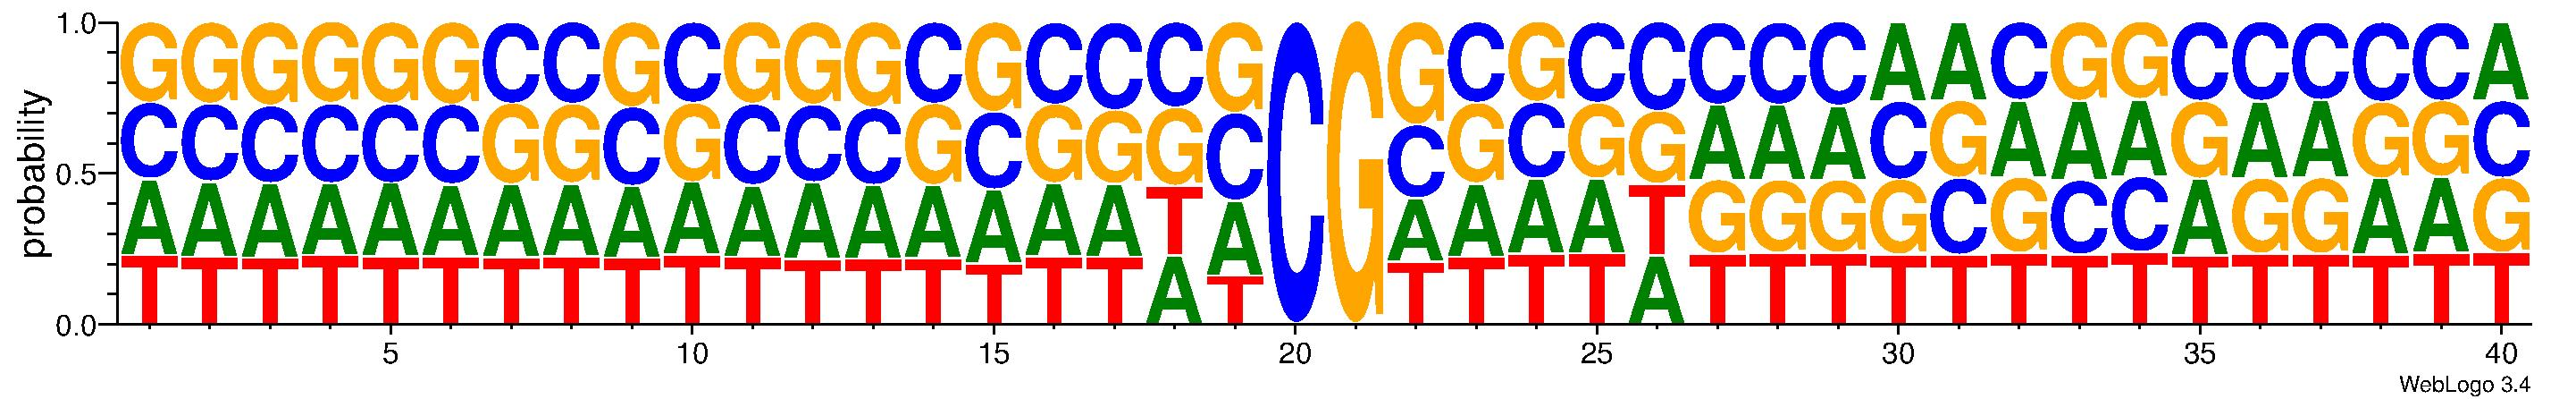

not methylated:


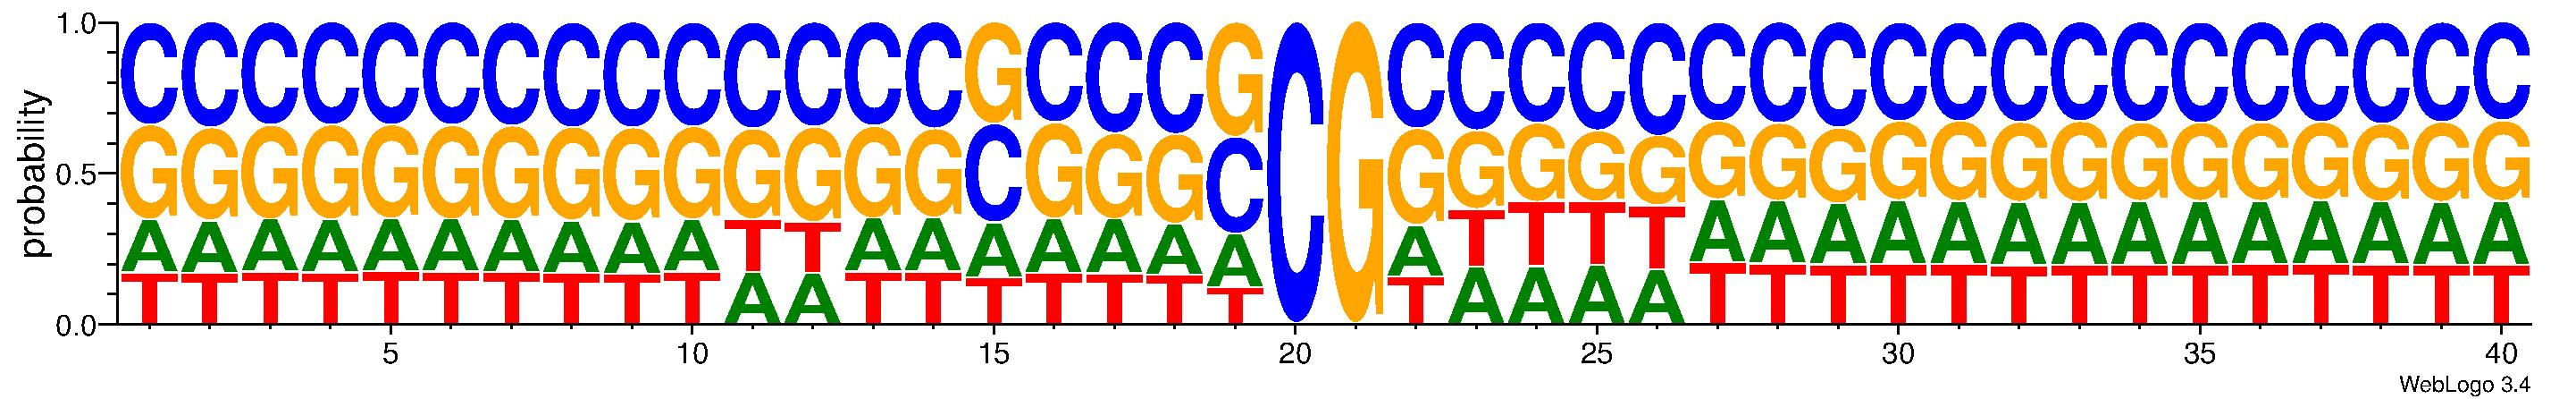

In [13]:
print 'methylated:'
display(Image('small_meth_logo.jpg'))
print 'not methylated:'
display(Image('small_nonmeth_logo.jpg'))

---

## Create fasta files for de novo motif detection



In [14]:
plus,minus=1000,1000
probe_to_fasta('small_meth_probes.csv','small_meth_seq_4_motif.fa',plus=plus,minus=minus)
probe_to_fasta('small_nonmeth_probes.csv','small_nonmeth_seq_4_motif.fa',plus=plus,minus=minus)

---

## Create csv files to load for naive prediction

- Overlapping sequence context can lead to memorizing/overfitting data
    - first  create a set of not overlapping probes

#### Create set of not overlapping probes

In [5]:
%%bash
cat meth_probes.csv nonmeth_probes.csv | sort -nk2,2 -nk3,3 > all_probes_sorted.csv

In [6]:
window=1000
with open('all_probes_sorted.csv') as fh:
    accepted_probes=[['id','chrom',0,'strand','beta']]
    for line in fh:
        probe_id,chrom,pos,strand,beta=line.split('\t')
        pos,beta=int(pos),float(beta)
        if (chrom!=accepted_probes[-1][1] or
            pos > accepted_probes[-1][2] + window ):
            accepted_probes.append([probe_id,chrom,pos,strand,beta])
accepted_probes.pop(0)
accepted_probes=pd.DataFrame(accepted_probes,columns=['id','chrom','pos','strand','beta'])

#### Not methylated probes are much more strongly clustered! Select a balanced sized random subset.

In [7]:
print len(accepted_probes[accepted_probes['beta']<=0.2])
print len(accepted_probes[accepted_probes['beta']>=0.8])

30147
123586


In [8]:
#shuffle it
new_idx=np.random.permutation(len(accepted_probes))
accepted_probes=accepted_probes.iloc[new_idx,:].reset_index(drop=True)

#select equal n probes
N=30000
balanced_acc_pr=pd.concat([accepted_probes[accepted_probes['beta']<=0.2][:N],
                           accepted_probes[accepted_probes['beta']>=0.8][:N]])

#shuffle it again
new_idx=np.random.permutation(len(balanced_acc_pr))
balanced_acc_pr=balanced_acc_pr.iloc[new_idx,:].reset_index(drop=True)

In [9]:
def probe_to_csv(input_df,output_fname,ref_dict,plus=100,minus=100):
    """
    Create relatively small csv files from pandas df of probes.
    
    Used in naive prediction as feauture vectors.
    """

    with open(output_fname,'w') as out_f:
        for i in xrange(len(input_df)):
            out_f.write(make_naive_line(input_df.iloc[i,:],ref_dict))
                
def make_naive_line(line,ref_dict):
    """Transform annotation line into naive feature vector line."""
    probe_id,chrom,pos,strand,beta=line

    #seq depending on strand
    if strand=="F":
        out_line = '\t'.join([probe_id]+map(base_to_num,ref_dict[chrom].seq[
                        pos-minus:pos+plus]))
    elif strand=="R":
        out_line = '\t'.join([probe_id]+map(base_to_num,ref_dict[chrom].seq[
                        pos-plus:pos+minus].reverse_complement()))
        
    #label depending on met
    if beta <=0.2:
        out_line+='\t0\n'
    elif beta >=0.8:
        out_line+='\t1\n'
    else:
        raise Exception # bad methylation value
        
    return out_line
                

def base_to_num(base):
    """
    Return a small unique number for each base.
    
    Doing this to turn categorical data into numeric ones.
    Should be checked, if the choice of order makes difference!
    
    """

    if (base =='a' or base=='A'):
        return '1'
    if (base =='c' or base=='C'):
        return '2'
    if (base =='g' or base=='G'):
        return '3'
    if (base =='t' or base=='T'):
        return '4'
    else:
        return '0'

#### Create the csv files

In [10]:
plus,minus=500,500
probe_to_csv(balanced_acc_pr,'meth_feat_vect.csv',ref_dict,plus=plus,minus=minus)

---
## Alternative set:

Trying to create much larger training set, tahn the not overlapping ones


- validation and test examples are not overlapping with train data
- validation and test examples can overlap with themselves
- train examples can overlap with themselves


Note: hard train,valid,test sets! cannot be changed for cross validation

#### Select a random subset for train and validation

In [21]:
#select a random subset for train and validation
N_valid=10000
N_test=10000

#set seed to make the selection reproducible
rng=np.random.RandomState(42)

#load data
#
# there is some weird thing going on with chr sometimes
# integers sometimes characters, this is a workaround
#
all_probes=pd.read_csv('all_probes_sorted.csv',sep='\t',dtype=object)
all_probes.columns=['id','chrom','pos','strand','beta']
all_probes['pos']=np.int32(all_probes['pos'])
all_probes['beta']=np.float32(all_probes['beta'])

#shuffle it
new_idx=rng.permutation(len(all_probes))
all_probes=all_probes.iloc[new_idx,:].reset_index(drop=True)

#select validation probes
valid_meth_probes=all_probes[all_probes['beta']>=0.8][:N_valid]
valid_nonmeth_probes=all_probes[all_probes['beta']<=0.2][:N_valid]

#select test probes
test_meth_probes=all_probes[all_probes['beta']>=0.8][N_valid:N_valid+N_test]
test_nonmeth_probes=all_probes[all_probes['beta']<=0.2][N_valid:N_valid+N_test]

#gather all selected probes
val_test_probes=pd.concat([valid_meth_probes,valid_nonmeth_probes,
                           test_meth_probes,test_nonmeth_probes])

#### Merge filter

In [22]:
# merge filter
window=500

accepted_probes=[]

# sort probes
val_test_probes=val_test_probes.sort_values(['chrom','pos']).reset_index(drop=True)
all_probes=all_probes.sort_values(['chrom','pos']).reset_index(drop=True)

#loop over chroms
for chrom in sorted(set(all_probes['chrom'])):
    print chrom,
    #get a smaller df, for the probes on the chrom
    val_test_probes_tmp=val_test_probes[val_test_probes['chrom']==chrom].reset_index(drop=True)
    all_probes_tmp=all_probes[all_probes['chrom']==chrom].reset_index(drop=True)
    
    #get positions of probes
    val_test_probes_chr=list(val_test_probes_tmp['pos'])
    all_probes_chr=list(all_probes_tmp['pos'])

    #merge filter the probes
    i,j=0,0
    while(i <len(all_probes_chr) and j+2 < len(val_test_probes_chr)):
        if (all_probes_chr[i] >= val_test_probes_chr[j+1]): #adfjust j
            j+=1
        #accept if used position are far enough
        if (val_test_probes_chr[j] +window < all_probes_chr[i] and
            val_test_probes_chr[j+1] -window > all_probes_chr[i] ):
            accepted_probes.append(all_probes_tmp.loc[i,:])
        i+=1

1 10 11 12 13 14 15 16 17 18 19 2 20 21 22 3 4 5 6 7 8 9 X Y


In [23]:
accepted_probes=pd.DataFrame(accepted_probes)

#shuffle it
new_idx=rng.permutation(len(accepted_probes))
accepted_probes=accepted_probes.iloc[new_idx,:].reset_index(drop=True)

acc_m_probes=accepted_probes[accepted_probes['beta']>=0.8]
acc_nm_probes=accepted_probes[accepted_probes['beta']<=0.2]

print len(acc_m_probes),len(acc_nm_probes)

157276 59489


In [24]:
#select equal n probes
N=len(acc_nm_probes)
balanced_acc_pr=pd.concat([acc_m_probes[:N],acc_nm_probes[:N]])

#shuffle it again
new_idx=rng.permutation(len(balanced_acc_pr))
balanced_acc_pr=balanced_acc_pr.iloc[new_idx,:].reset_index(drop=True)

#gather and shuffle val test too
val_probes=pd.concat([valid_meth_probes,valid_nonmeth_probes])
test_probes=pd.concat([test_meth_probes,test_nonmeth_probes])

new_idx=rng.permutation(len(val_probes))
val_probes=val_probes.iloc[new_idx,:].reset_index(drop=True)

new_idx=rng.permutation(len(test_probes))
test_probes=test_probes.iloc[new_idx,:].reset_index(drop=True)

In [25]:
plus,minus=500,500
probe_to_csv(balanced_acc_pr,'big_train_feat_vect.csv',ref_dict,plus=plus,minus=minus)
probe_to_csv(val_probes,'big_val_feat_vect.csv',ref_dict,plus=plus,minus=minus)
probe_to_csv(test_probes,'big_test_feat_vect.csv',ref_dict,plus=plus,minus=minus)